In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import imread
import json
import gzip
import tarfile
import random
from hangul_utils import split_syllable_char, split_syllables, join_jamos
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'

print("packs loaded")

packs loaded


In [2]:
index_data_ko = []

with gzip.open('data/ko/index.json.gz', 'rt') as arc:
    index_data_ko.extend(json.load(arc))
    print("ko index loaded")
    
with tarfile.open('data/ko/data.tar.gz', "r|*") as tar:
    print("tar opened")
    img_data_ko = []
    for i, member in enumerate(index_data_ko):
        if i%10000 == 1:
            print("%2.0f%% complete (%d / %d)" % (i / len(index_data_ko) * 100, i, len(index_data_ko)))
        ti = tar.next()
        if ti.name != member['path']:
            print("ERROR: order doesn't match")
            break;
        f = tar.extractfile(ti)
        img_data_ko.append(1 - (imread(f)/255))
    img_ko = np.array(img_data_ko)
    del img_data_ko
    print("ko image loaded")

ko index loaded
tar opened
 0% complete (1 / 211500)
 5% complete (10001 / 211500)
 9% complete (20001 / 211500)
14% complete (30001 / 211500)
19% complete (40001 / 211500)
24% complete (50001 / 211500)
28% complete (60001 / 211500)
33% complete (70001 / 211500)
38% complete (80001 / 211500)
43% complete (90001 / 211500)
47% complete (100001 / 211500)
52% complete (110001 / 211500)
57% complete (120001 / 211500)
61% complete (130001 / 211500)
66% complete (140001 / 211500)
71% complete (150001 / 211500)
76% complete (160001 / 211500)
80% complete (170001 / 211500)
85% complete (180001 / 211500)
90% complete (190001 / 211500)
95% complete (200001 / 211500)
99% complete (210001 / 211500)
ko image loaded


In [5]:
ko_chset_cho = ["ㄱ", "ㄲ", "ㄴ", "ㄷ", "ㄸ", "ㄹ", "ㅁ", "ㅂ", "ㅃ", "ㅅ", "ㅆ", "ㅇ", "ㅈ", "ㅉ", "ㅊ", "ㅋ", "ㅌ", "ㅍ", "ㅎ"]
ko_chset_jung = ["ㅏ", "ㅐ", "ㅑ", "ㅒ", "ㅓ", "ㅔ", "ㅕ", "ㅖ", "ㅗ", "ㅘ", "ㅙ", "ㅚ", "ㅛ", "ㅜ", "ㅝ", "ㅞ", "ㅟ", "ㅠ", "ㅡ", "ㅢ", "ㅣ"]
ko_chset_jong = ["X", "ㄱ", "ㄲ", "ㄳ", "ㄴ", "ㄵ", "ㄶ", "ㄷ", "ㄹ", "ㄺ", "ㄻ", "ㄼ", "ㄽ", "ㄾ", "ㄿ", "ㅀ", "ㅁ", "ㅂ", "ㅄ", "ㅅ", "ㅆ", "ㅇ", "ㅈ", "ㅊ", "ㅋ", "ㅌ", "ㅍ", "ㅎ"]

label_ko_cho = np.zeros([img_ko.shape[0], len(ko_chset_cho)])
label_ko_jung = np.zeros([img_ko.shape[0], len(ko_chset_jung)])
label_ko_jong = np.zeros([img_ko.shape[0], len(ko_chset_jong)])
for i, member in enumerate(index_data_ko):
    splited = split_syllable_char(member['target'])
    label_ko_cho[i][ko_chset_cho.index(splited[0])] = 1
    label_ko_jung[i][ko_chset_jung.index(splited[1])] = 1
    if len(splited) < 3:
        label_ko_jong[i][0] = 1
    else:
        label_ko_jong[i][ko_chset_jong.index(splited[2])] = 1
    
print("ko label loaded")

ko label loaded


In [6]:
def getIndex(l, indexes):
    return [l[i] for i in indexes]

def shuffle(n, *lists):
    perm = np.random.permutation(n)
    lists = list(lists)
    for i in range(len(lists)):
        if hasattr(lists[i], "shape"):
            lists[i] = lists[i][perm]
        else:
            lists[i] = getIndex(lists[i], perm)
    return tuple(lists)

img_ko, label_ko_cho, label_ko_jung, label_ko_jong, index_data_ko = shuffle(
    img_ko.shape[0], img_ko, label_ko_cho, label_ko_jung, label_ko_jong, index_data_ko)

print("shuffled")

shuffled


(211500, 32, 32)
{'target': '째', 'weight': 'BOLD', 'path': '0153664.png', 'font': 'NanumGothic'}
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.]


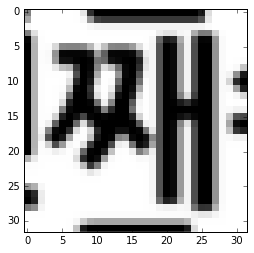

In [8]:
print(img_ko.shape)
plt.figure()
plt.imshow(img_ko[0], interpolation='none')
print(index_data_ko[0])
print(label_ko_cho[0])

In [9]:
trainimg = img_ko[:-5000]
trainlabel_cho = label_ko_cho[:-5000]
trainlabel_jung = label_ko_jung[:-5000]
trainlabel_jong = label_ko_jong[:-5000]
testimg = img_ko[-5000:]
testlabel_cho = label_ko_cho[-5000:]
testlabel_jung = label_ko_jung[-5000:]
testlabel_jong = label_ko_jong[-5000:]
randidx = np.random.randint(trainimg.shape[0], size=2)

def get_batch(i, batch_size, input_var):
    if batch_size > input_var.shape[0]:
        return input_var
    start = (i*batch_size)%input_var.shape[0]
    overflow = start + batch_size - input_var.shape[0]
    if overflow <= 0:
        return input_var[start:start+batch_size]
    else:
        return np.r_[input_var[start:], input_var[:overflow]]
    
def build_cnn(cnn_shape, patch_shape, X):
    n_before = int(X.get_shape()[3])
    layer = X
    for idx, val in enumerate(cnn_shape):
        W = tf.Variable(tf.truncated_normal([patch_shape[0], patch_shape[1], n_before, val], stddev=0.1))
        b = tf.Variable(tf.constant(0.1, shape=[val]))
        layer = tf.nn.relu(tf.nn.conv2d(layer, W, strides=[1, 1, 1, 1], padding='SAME') + b)
        layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        n_before = val
    layer_shape = layer.get_shape().as_list()
    n_out = layer_shape[1] * layer_shape[2] * layer_shape[3]
    return tf.reshape(layer, [-1, n_out])
    
def build_nn(shape, X, Y):
    n_before = int(X.get_shape()[1])
    n_out = int(Y.get_shape()[1])
    layer = X
    for idx, val in enumerate(shape):
        W = tf.Variable(tf.truncated_normal([n_before, val], stddev=0.1))
        b = tf.Variable(tf.constant(0.1, shape=[val]))
        layer = tf.nn.relu(tf.matmul(layer, W)+b)
        n_before = val
    W = tf.Variable(tf.truncated_normal([n_before, n_out], stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[n_out]))
    return tf.matmul(layer, W)+b

print("function loaded")

function loaded


In [10]:
X = tf.placeholder(tf.float32, [None, 32, 32])
Y_cho = tf.placeholder(tf.float32, [None, len(ko_chset_cho)])
Y_jung = tf.placeholder(tf.float32, [None, len(ko_chset_jung)])
Y_jong = tf.placeholder(tf.float32, [None, len(ko_chset_jong)])

cnn_layer = build_cnn([32, 64], [5,5], tf.reshape(X, [-1, 32, 32, 1]))
dense_cho = build_nn([512], cnn_layer, Y_cho)
dense_jung = build_nn([512], cnn_layer, Y_jung)
dense_jong = build_nn([512], cnn_layer, Y_jong)
keep_prob = tf.placeholder(tf.float32)
dropout_cho = tf.nn.dropout(dense_cho, keep_prob)
dropout_jung = tf.nn.dropout(dense_jung, keep_prob)
dropout_jong = tf.nn.dropout(dense_jong, keep_prob)
h_cho = tf.nn.softmax(dropout_cho)
h_jung = tf.nn.softmax(dropout_jung)
h_jong = tf.nn.softmax(dropout_jong)

learning_rate = tf.placeholder(tf.float32)
cost_cho = tf.reduce_mean(-tf.reduce_sum(Y_cho * tf.log(h_cho), reduction_indices=[1]))
cost_jung = tf.reduce_mean(-tf.reduce_sum(Y_jung * tf.log(h_jung), reduction_indices=[1]))
cost_jong = tf.reduce_mean(-tf.reduce_sum(Y_jong * tf.log(h_jong), reduction_indices=[1]))

train = tf.train.AdamOptimizer(learning_rate).minimize(cost_cho + cost_jung + cost_jong)

In [13]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

trainsize = trainimg.shape[0]
batchsize = 30
batch_per_epoch = int(trainsize/batchsize)
print ("Training %d, mini-batch %d * %d" % (trainsize, batchsize, batch_per_epoch))

correct_cho = tf.equal(tf.argmax(Y_cho,1), tf.argmax(h_cho,1))
correct_jung = tf.equal(tf.argmax(Y_jung,1), tf.argmax(h_jung,1))
correct_jong = tf.equal(tf.argmax(Y_jong,1), tf.argmax(h_jong,1))
correct_all = tf.logical_and(tf.logical_and(correct_cho, correct_jung), correct_jong)
accuracy = tf.reduce_mean(tf.cast(correct_all, tf.float32))

lr = 0.0003
for i in range(batch_per_epoch*5):
    if i % 100 == 0 :
        print ("%6dth epoch : test accuracy = %.3f" % \
               (i / batch_per_epoch, sess.run(accuracy, feed_dict={X:testimg,
                                                                   Y_cho:testlabel_cho,
                                                                   Y_jung:testlabel_jung,
                                                                   Y_jong:testlabel_jong, keep_prob:1})))
        
    batch_x = get_batch(i, batchsize, trainimg)
    batch_y_cho = get_batch(i, batchsize, trainlabel_cho)
    batch_y_jung = get_batch(i, batchsize, trainlabel_jung)
    batch_y_jong = get_batch(i, batchsize, trainlabel_jong)
    sess.run(train, feed_dict={X:batch_x, Y_cho:batch_y_cho,
                               Y_jung:batch_y_jung,
                               Y_jong:batch_y_jong,
                               keep_prob:0.5, learning_rate:lr})
    lr = lr * (1 - 0.0003)
    
train_accuracy = 0
for i in range(batch_per_epoch):
    batch_x = get_batch(i, batchsize, trainimg)
    batch_y_cho = get_batch(i, batchsize, trainlabel_cho)
    batch_y_jung = get_batch(i, batchsize, trainlabel_jung)
    batch_y_jong = get_batch(i, batchsize, trainlabel_jong)
    train_accuracy += sess.run(accuracy, feed_dict={X:batch_x, Y_cho:batch_y_cho,
                               Y_jung:batch_y_jung,
                               Y_jong:batch_y_jong, keep_prob:1})
        
print ("train complete : test accuracy = %.3f" % (sess.run(accuracy, feed_dict={X:testimg,
                                                                   Y_cho:testlabel_cho,
                                                                   Y_jung:testlabel_jung,
                                                                   Y_jong:testlabel_jong, keep_prob:1})))
print ("                 train accuracy = %.3f" % (train_accuracy / batch_per_epoch))

Training 206500, mini-batch 30 * 6883
     0th epoch : test accuracy = 0.000
     0th epoch : test accuracy = 0.010
     0th epoch : test accuracy = 0.053
     0th epoch : test accuracy = 0.092
     0th epoch : test accuracy = 0.174
     0th epoch : test accuracy = 0.215
     0th epoch : test accuracy = 0.285
     0th epoch : test accuracy = 0.362
     0th epoch : test accuracy = 0.410
     0th epoch : test accuracy = 0.456
     0th epoch : test accuracy = 0.487
     0th epoch : test accuracy = 0.518
     0th epoch : test accuracy = 0.572
     0th epoch : test accuracy = 0.589
     0th epoch : test accuracy = 0.628
     0th epoch : test accuracy = 0.649
     0th epoch : test accuracy = 0.659
     0th epoch : test accuracy = 0.675
     0th epoch : test accuracy = 0.705
     0th epoch : test accuracy = 0.715
     0th epoch : test accuracy = 0.729
     0th epoch : test accuracy = 0.746
     0th epoch : test accuracy = 0.737
     0th epoch : test accuracy = 0.748
     0th epoch : test accu

KeyboardInterrupt: 